# Test technique Data Scientist — Ubisoft

Ce notebook présente le travail réalisé dans le cadre d’un test technique pour le poste de Scientifique des données - Canada Analytics Team chez Ubisoft.  

L’objectif de ce projet est d’explorer, analyser et exploiter les données fournies afin de répondre aux questions définies dans l’énoncé.  
L’approche suivie est volontairement structurée et reproductible, et couvre les principales étapes d’un projet data : compréhension des données, nettoyage, analyse exploratoire, modélisation et interprétation des résultats.  

> This notebook presents the work carried out as part of a technical test for a Data Scientist position at Ubisoft.
>
> The objective of this project is to explore, analyze and leverage the provided dataset in order to answer the questions described in the exercise statement.  
> The analysis follows a structured and reproducible data science workflow, including data exploration, cleaning, exploratory analysis, modeling, and interpretation of results.
>
---


### Question 1
– Expliquez brièvement (maximum 2 lignes par colonne) votre compréhension du contenu de chaque colonne.
> – Briefly explain (max 2 lines per column) your understanding of what each column contains.

In [232]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import seaborn as sns

pd.set_option("display.max_columns", None)

In [233]:
df = pd.read_csv("data/technical_test_data(in).csv")
print(len(df))
df.head()

58510


,sessionid,playerid,serverdate_first,serverdate_last,clientdate_first,clientdate_last,dateid,countrycode,gameversion,playersessions_index,playdays_index,sessionuptime_duration,cum_playtime_duration,session_playtime_duration,population
0,-681224192,1497703947,6/6/2024 1:05,6/6/2024 1:32,6/6/2024 1:04,6/6/2024 1:32,20240606,BR,Full,1,1,1660,1287,1287,pop2
1,439644068,-582178240,6/6/2024 2:42,6/6/2024 2:42,6/6/2024 2:41,6/6/2024 2:41,20240606,DE,Full,9678,1,6,0,0,pop1
2,586332046,-582178240,6/6/2024 0:03,6/6/2024 0:03,6/6/2024 0:03,6/6/2024 0:03,20240606,DE,Full,9655,1,6,0,0,pop1
3,-78988545,228829462,6/6/2024 0:02,6/6/2024 3:57,6/6/2024 0:02,6/6/2024 3:57,20240606,ZA,Full,13,3,14100,0,0,pop1
4,69020027,-582178240,6/6/2024 23:59,6/6/2024 23:59,6/6/2024 23:59,6/6/2024 23:59,20240606,DE,Full,9744,1,7,0,0,pop1


**sessionid**  
Identifiant unique d’une session (persistante), qui peut correspondre a un client ouvert, un monde ou un compte connecté
> A unique identifier for a (persistent) session, which can correspond to an open client, a world, or a connected account.

**playerid**  
Identifiant unique du joueur, permettant de suivre son activité dans différentes sessions
> A unique identifier for the player, allowing their activity to be tracked across different sessions.

**serverdate_first**  
Date et heure côté serveur correspondant au début de l’activité observée pour cette session et ce joueur
> Server-side date and time corresponding to the start of the observed activity for this session and this player

**serverdate_last**  
Date et heure côté serveur correspondant à la fin de l’activité observée pour cette session et ce joueur
> Server-side date and time corresponding to the end of the observed activity for this session and this player

**clientdate_first**  
Date et heure côté client correspondant au début de l’activité du joueur dans la session
> Client-side date and time corresponding to the start of the player's activity in the session

**clientdate_last**  
Date et heure côté client correspondant à la fin de l’activité du joueur dans la session
> Client-side date and time corresponding to the end of the player's activity in the session

**dateid**  
Date de la session
> Session date

**countrycode**  
Code pays du joueur.
> Country code of the player

**gameversion**  
Version du jeu utilisée par le joueur, pouvant servir à distinguer différentes versions ou groupes de test
> The version of the game used by the player, which can be used to distinguish between different versions or test groups.

**playersessions_index**  
Index représentant la progression du joueur dans son historique de sessions
> Index representing the player's progress in their session history

**playdays_index**  
Nombre de jours durant lesquels cette session a été active pour le joueur
> Number of days this session was active for the player

**sessionuptime_duration**  
Durée totale en secondes pendant laquelle la session a été active pour ce joueur pour le jour observé
> Total time in seconds that the session was active for this player on the observed day

**cum_playtime_duration**  
Temps de jeu cumulé en secondes pour cette session
> Total playing time in seconds for this session

**session_playtime_duration**  
Temps de jeu en secondes pour cette session et pour le jour observé
> Playing time in seconds for this session and for the observed day

**population**  
Groupe d'observation pour de l'A/B testing 
> Observation group for A/B testing
---


### Question 2
– Analysez la qualité des données et effectuez un nettoyage. Signalez toutes les anomalies détectées (le cas échéant) et expliquez comment vous les corrigeriez. Fournissez des exemples ou du code si vous pensez que cela peut être utile, mais restez concis.
> – Look at the quality of the dataset and perform some data cleaning. Report all the types of anomalies you've found (if any) and
explain how you'd fix them. Provide examples or code if you think it helps but be concise.

In [234]:
overview = pd.DataFrame({
    "dtype": df.dtypes,
    "missing": df.isna().sum(),
    "n_unique": df.nunique(dropna=False)
})

duplicated_rows = df.duplicated().sum()

date_cols = ["serverdate_first","serverdate_last","clientdate_first","clientdate_last"]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

temporal_error = {
    "server_first_after_last": (df["serverdate_first"] > df["serverdate_last"]).sum(),
    "client_first_after_last": (df["clientdate_first"] > df["clientdate_last"]).sum(),
}

dur_cols = ["sessionuptime_duration","cum_playtime_duration","session_playtime_duration"]
for c in dur_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

duration_error = {
    "NEGATIVE_sessionuptime": (df["sessionuptime_duration"] < 0).sum(),
    "NEGATIVE_session_playtime": (df["session_playtime_duration"] < 0).sum(),
    "INCONSISTENCY_playtime_sessionuptime": (df["session_playtime_duration"] > df["sessionuptime_duration"]).sum()
}
print("- type, missing&unique values")
print(overview)
print("- duplicated row")
print(duplicated_rows)
print("- checking temporal error")
print(temporal_error)
print("- checking duration error")
print(duration_error)


- type, missing&unique values
                            dtype  missing  n_unique
sessionid                   int64        0     55696
playerid                    int64        0      4834
serverdate_first           object        0     49448
serverdate_last            object        0     49656
clientdate_first           object        0     50117
clientdate_last            object        0     50200
dateid                      int64        0       183
countrycode                object        2       104
gameversion                object        1         2
playersessions_index        int64        0      9482
playdays_index              int64        0        12
sessionuptime_duration      int64        0     10506
cum_playtime_duration       int64        0     12479
session_playtime_duration   int64        0     12476
population                 object        0         2
- duplicated row
0
- checking temporal error
{'server_first_after_last': np.int64(0), 'client_first_after_last': np.int64(

- mauvais type pour les dates -> conversion en `datetime`
- valeurs manquantes pour `countrycode`, `gameversion` -> exclusion des données
- pas de duplica de valeurs
- pas d'incohérence de début/fin de session ou joueur
- temps de jeu négatif, incohérence entre le l'arrivé du joueur et début de la session -> exclusion des données

>- Incorrect date type -> converted to `datetime`
>- Missing values ​​for `countrycode`, `gameversion` -> excluded from data
>- No duplicate values
>- No inconsistency in session start/end or player
>- Negative playtime, inconsistency between player arrival and session start -> excluded from data

In [235]:
print(len(df))

df = df.dropna()
mask_1 = df["session_playtime_duration"] < 0
mask_2 = df["session_playtime_duration"] > df["sessionuptime_duration"]

masks = mask_1 | mask_2 
df = df.loc[~masks]
print(len(df))

58510
58193


---

### Question 3
– Explorez les données un peu. Proposez quelques visualisations (maximum 3) que vous jugez pertinentes pour les développeurs du jeu, et fournissez une interprétation des résultats.
> – Explore the data a bit. Provide a few (max 3) visualizations that you think would be interesting to the developers of that game, and provide some interpretation. No need to share the code for this part.

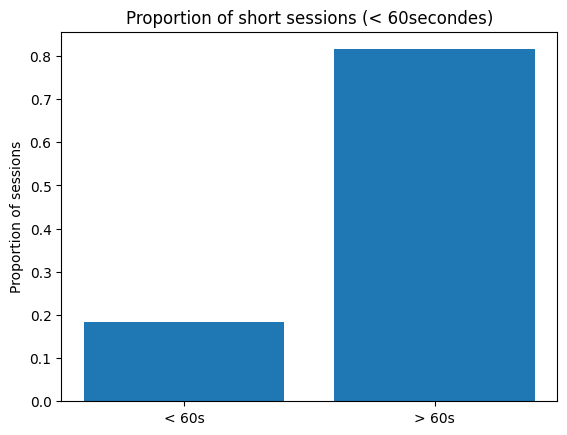

In [236]:
df["short_session"] = df["sessionuptime_duration"] < 60
short_rate_mean = df["short_session"].mean()

plt.bar(["< 60s", "> 60s"], [short_rate_mean, 1 - short_rate_mean])
plt.ylabel("Proportion of sessions")
plt.title("Proportion of short sessions (< 60secondes)")
plt.show()

Une part importante des sessions a une durée inférieur à 60 secondes ce qui peut correspondre à des échecs de connexion, des problèmes techniques, des abandons rapides de joueurs
>A significant proportion of sessions last less than 60 seconds, which can be attributed to connection failures, technical issues, or players quickly leaving the site.

---

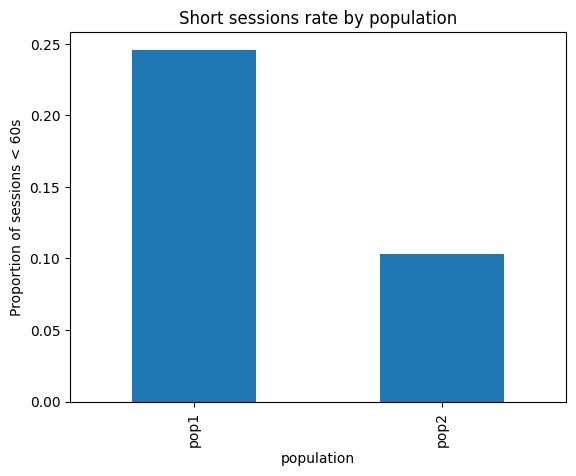

In [237]:
short_by_pop = (df.groupby("population")["short_session"].mean().sort_values(ascending=False))

short_by_pop.plot(kind="bar")
plt.ylabel("Proportion of sessions < 60s")
plt.title("Short sessions rate by population")
plt.show()

Le taux de sessions très courtes est nettement différent entre les populations, la pop1 présente une proportion bien plus élevé de sessions de moins de 60 secondes.
>The rate of very short sessions is clearly different between populations, with pop1 showing a much higher proportion of sessions of less than 60 seconds.
---

/var/folders/kl/3nc79ycx61v13jbqlw61nnfw0000gn/T/ipykernel_13334/1185601942.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=populations, showfliers=False)


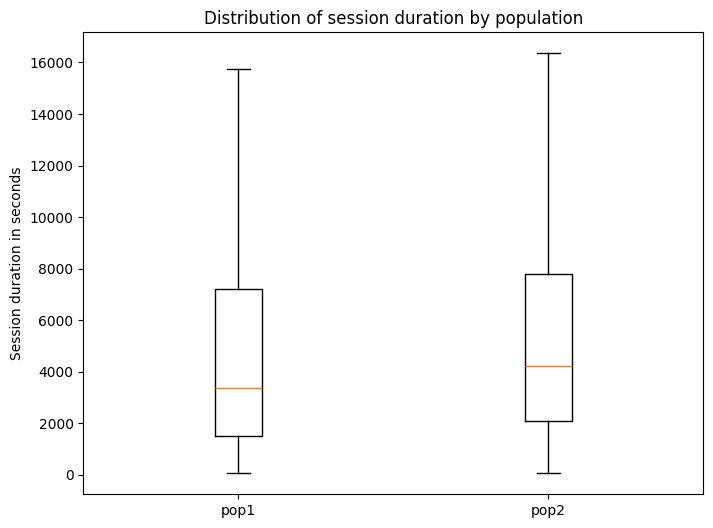

In [238]:
df_session = df[df["sessionuptime_duration"] > 60].copy()
populations = ["pop1", "pop2"]
data = []
for pop in populations:
    durations = df_session.loc[
        df_session["population"] == pop,
        "sessionuptime_duration"
    ]
    data.append(durations)

plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=populations, showfliers=False)
plt.ylabel("Session duration in seconds")
plt.title("Distribution of session duration by population")
plt.show()


J'ai exclu les sessions courtes pour verifier la distribution de durée de session des différentes populations, et il apparait clairement que la pop2 présente une durée médiane plus élevée ainsi qu’une dispersion plus importante
>I excluded short sessions to verify the session duration distribution of the different populations, and it clearly appears that pop2 has a higher median duration as well as a greater dispersion.
---

### Question 4
– Créez un modèle de classification qui prédit, pour chaque session de joueur, s'il s'agit de sa dernière session ou non. La qualité du modèle importe peu ; ce qui nous intéresse, c'est votre approche.
> – Make a classifier model that predicts, for each player-session, whether this is the last session of that player or not. The model doesn't need to be good, we’re mostly interested in how you approach this kind of task.

In [239]:
print("Players:", df["playerid"].nunique())
print("Sessions:", df["sessionid"].nunique())

filter_max_time = df.groupby("playerid")["serverdate_last"].transform("max")
df["last_session"] = (df["serverdate_last"] == filter_max_time).astype(int)

print(df["last_session"].value_counts())

Players: 4823
Sessions: 55388
last_session
0    53336
1     4857
Name: count, dtype: int64


J'ai indiqué pour chaque session si c'était la dernière du joueurs avec 1 : TRUE 0 : FALSE
Une analyse exploratoire du dataset m'a montré que des sessions apparaissaient plusieurs fois, il est donc cohérent que le nombre de dernière session soit plus importante que le nombre de joueur, ça ne posera pas de problème lors de l'entrainement du modèle.
>I indicated for each session whether it was the player's last with 1: TRUE 0: FALSE. An exploratory analysis of the dataset showed me that some sessions appeared multiple times, so it's consistent that the number of the last session is greater than the number of players; this won't cause any problems when training the model.
---

In [240]:
players = df["playerid"].unique()

train_players, test_players = train_test_split(players, test_size=0.2, random_state=42)

train_df = df[df["playerid"].isin(train_players)].copy()
test_df  = df[df["playerid"].isin(test_players)].copy()

print("Train rows:", len(train_df))
print("Test rows:", len(test_df))

Train rows: 47046
Test rows: 11147


J'ai ensuite séparé les données en entrainement et test selon les joueurs, cela permet de ne pas retrouver un joueur simultanément dans les données d'entrainement et de test. Nous pourrons ensuite évaluer les performances du modèle sur les données de test.
>I then separated the training and test data according to the players, which prevents a player from appearing simultaneously in both the training and test data. We can then evaluate the model's performance on the test data.
---

In [241]:
features = [
    "sessionuptime_duration",
    "session_playtime_duration",
    "playdays_index",
    "playersessions_index"
]

X_train = train_df[features]
y_train = train_df["last_session"]

X_test = test_df[features]
y_test = test_df["last_session"]

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)

print("DummyClassifier results:")
print(classification_report(y_test, y_pred_dummy, digits=2))


DummyClassifier results:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     10178
           1       0.00      0.00      0.00       969

    accuracy                           0.91     11147
   macro avg       0.46      0.50      0.48     11147
weighted avg       0.83      0.91      0.87     11147



/Applications/anaconda3/envs/ubisoft/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Applications/anaconda3/envs/ubisoft/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Applications/anaconda3/envs/ubisoft/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

Le DummyClassifier sert de modèle de référence en prédisant systématiquement la classe majoritaire (pas la dernière session du joueur). L'accuracy est élevée 91%, forcément il identifie facilement les sessions qui ne sont pas les dernières du joueurs, mais un rappel nul lorsqu'il s'agit d'identifier la dernière session du joueur. La métrique est inadaptée ici et le modèle ne permet pas de faire prédiction.
>The DummyClassifier serves as a reference model by predicting only the majority class (not the player's last session). Its accuracy is high at 91%, naturally allowing it to easily identify sessions that are not the player's most recent, but it has zero recall when it comes to identifying the player's last session. The metric is therefore unsuitable, and the model cannot make predictions.
---


In [242]:
first_session = df.groupby("playerid")["serverdate_last"].transform("min")
df["days_since_first_session"] = (df["serverdate_last"] - first_session).dt.days

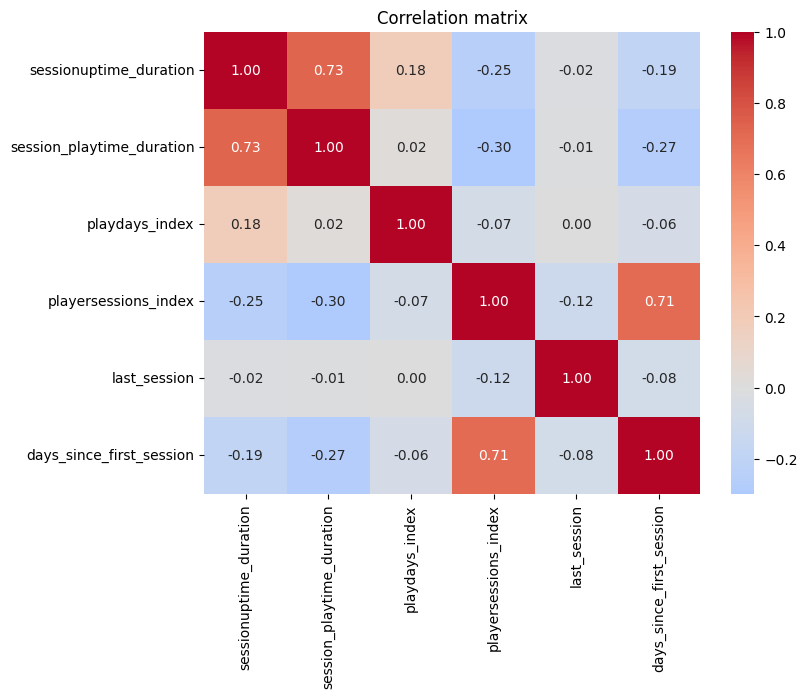

In [243]:
corr_features = [
    "sessionuptime_duration",
    "session_playtime_duration",
    "playdays_index",
    "playersessions_index",
    "last_session",
    "days_since_first_session"
]

corr_matrix = df[corr_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Correlation matrix")
plt.show()

Pour le choix de la feature engineered, je me suis appuyé sur une analyse de corrélation afin de mieux comprendre les relations entre les variables existantes. Cette analyse met en évidence une corrélation modérée entre `playersessions_index` et certaines métriques d’activité, telles que `session_playtime_duration`, suggérant que l’index de session capture une forme de progression dans le comportement du joueur au fil du temps. Cependant, `playersessions_index` représente une progression ordinale sans information explicite sur l’échelle temporelle réelle. J'ai donc créé la variable `days_since_first_session` pour ajouter cette dimension temporelle. Elle permet de mesurer l’ancienneté et le rythme d’activité du joueur, offrant une information complémentaire susceptible d’aider le modèle à identifier les sessions survenant tard dans l’historique du joueur, et donc plus susceptibles d’être les dernières.
>For the feature engineered selection, I relied on correlation analysis to better understand the relationships between the existing variables. This analysis highlights a moderate correlation between `playersessions_index` and certain activity metrics, such as `session_playtime_duration`, suggesting that the session index captures a form of progression in player behavior over time. However, `playersessions_index` represents an ordinal progression without explicit information about the actual time scale. I therefore created the variable `days_since_first_session` to add this temporal dimension. It allows us to measure the player's seniority and activity rate, providing additional information that can help the model identify sessions occurring later in the player's history, and therefore more likely to be the most recent.
---

In [244]:
features = [
    "sessionuptime_duration",
    "session_playtime_duration",
    "playdays_index",
    "playersessions_index",
    "days_since_first_session"
]

players = df["playerid"].unique()
train_players, test_players = train_test_split(players, test_size=0.2, random_state=42)

train_df = df[df["playerid"].isin(train_players)].copy()
test_df  = df[df["playerid"].isin(test_players)].copy()

X_train = train_df[features]
y_train = train_df["last_session"]

X_test = test_df[features]
y_test = test_df["last_session"]

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print("Logistic Regression results:")
print(classification_report(y_test, y_pred, digits=3))


Logistic Regression results:
              precision    recall  f1-score   support

           0      0.969     0.290     0.447     10178
           1      0.108     0.904     0.193       969

    accuracy                          0.344     11147
   macro avg      0.539     0.597     0.320     11147
weighted avg      0.895     0.344     0.425     11147



J'ai choisi la régression logistique avec pondération de classe comme premier modèle car elle est simple à interpréter et adaptée à un probleme de classification binaire déséquilibré. En comparaison avec DummyClassifier, le modèle parvient a identifier une grande majorité des dernières sessions, avec un rappel de 0.90 pour la classe positive. Malheureusement la précision et l’accuracy baisse, un comportement cependant normal dans un dataset fortement déséquilibré.
>I chose class-weighted logistic regression as my first model because it is easy to interpret and well-suited to a binary imbalanced classification problem. Compared to DummyClassifier, the model successfully identifies a large majority of the most recent sessions, with a recall of 0.90 for the positive class. Unfortunately, precision and accuracy decrease, which is to be expected in a highly imbalanced dataset.
---

### Question 5
– Quelles autres variables, non disponibles dans cet ensemble de données, vous sembleraient utiles ?
> – What other features, not available in this dataset, do you think would be useful?

La liste potentielle de variables utiles permettant de déterminer l'engagement d'un joueur peut être très importante. Epic Game s'est longuement appuyé sur des analyses comportementales de joueurs afin de les garder actifs. J'aime beaucoup cette notion de psychologie qui permettrait de favoriser l'engagement du joueur en déterminant ce qui le garde accroché à un jeu. Un profilage comportemental du joueur, bien qu'étant une notion risquée permettrait de faciliter la prédiction du churn.  
  
L’approche la plus réaliste consiste à construire un profil comportemental à partir de signaux observables. J'ai réalisé une liste non-exhaustive de variables qui me semblent pertinentes et facile à obtenir pour anticiper le comportement d'un joueur.

- **moyenne/médiane de temps de jeux** Un indicateur simple qui permet de déterminer l'engagement moyen du joueur dans le temps, et de le comparer à son propre historique ou à celui d’autres joueurs
- **évolution du temps de jeu** Permet d'évaluer la tendance des sessions du joueurs, de comprendre le cycle, et la cohérence avec celle des autres joueurs
- **délais entre sessions** Estimation de l'augmentation progressive entre plusieurs sessions de jeu 
- **régularité entre sessions** Permet de comprendre le rythme de jeu du joueur, sa régularité, son engagement, sa fréquence
- **progression du joueur** Déterminer le rythme de progression du joueur, comprendre ses difficultés
- **activité du joueur** Mesurer l'activité/AFK/menus
- **niveau du joueur** Indicateur pertinent pour comprendre l'engagement du joueur, s'il trouve encore de l'activité à réaliser dans la session
- **niveau de la session** Indicateur pour comprendre comment le joueur affronte la difficulté, niveau des ennemis, ratio K/D
- **succès/échec** Permet de comprendre la frustration/satisfaction du joueur en fonction des événements de la session
- **paliers débloqués** Permet de comprendre si un objectif est atteint, une perte de motivation possible
- **nouveautés/événements/maj** Comprendre si l'activité du joueur est en cohérence avec l'activité de la session, des nouveautés ou mise à jour proposée
- **interactions** Connaitre les interactions que le joueur a pu rencontrer et leur qualité (autres joueurs ou non joueurs), permet de déterminer si ces interactions ont un impact positif/négatif sur son comportement
- **amis** Information sur le comportement social du joueur et l'activité de ses amis pour comprendre le comportement de groupe/réseau
- **concurrence** Connaitre les plages de sortie ou d'activité de la concurrence pour déterminer l'engagement du joueur
- **achat in-game** Comprendre le comportement économique du joueur afin de déterminer son engagement économique et frustration en fonction de l'achat in-game
- **connexion/ping/erreurs** Mesurer la connexion du joueur pour comprendre ses attentes

Ces variables permettent de passer d’une analyse basée sur des sessions isolées à une compréhension dynamique du comportement du joueur dans le temps, ce qui est essentiel pour anticiper une fin de session.

>The list of potential variables that could help determine player engagement can be very large. Epic Games has long relied on behavioral player analysis to keep players active. I particularly appreciate this psychological approach, which aims to foster player engagement by understanding what keeps players hooked on a game.
Behavioral player profiling, although a delicate concept, could help facilitate churn prediction.
>
>The most realistic approach is to build a behavioral profile based on observable signals. Below is a non-exhaustive list of variables that I consider both relevant and relatively easy to obtain in order to anticipate player behavior.
>
>- **average/median playtime** A simple indicator used to assess a player’s average engagement over time and compare it either to their own historical behavior or to other players.
>- **playtime evolution** Helps evaluate trends in session duration, understand player cycles, and assess consistency with the behavior of other players.
>- **time between sessions** Estimation of the progressive increase in delay between consecutive play sessions.
>- **session regularity** Helps understand the player’s play rhythm, consistency, engagement, and frequency.
>- **player progression** Used to assess the player’s progression pace and identify potential difficulty points during gameplay.
>- **player activity** Measures active gameplay versus inactivity (AFK / menus).
>- **player level** A relevant indicator to understand engagement and whether the player still finds meaningful activities to complete during sessions.
>- **session difficulty level** Helps understand how the player faces difficulty, including enemy level and performance indicators such as K/D ratio.
>- **success/failure** Provides insight into player frustration or satisfaction based on session outcomes and in-game events.
>- **unlocked milestones** Helps identify whether major objectives have been reached, which may sometimes lead to a loss of motivation.
>- **new content/events/updates** Used to assess whether player activity aligns with newly released content, events, or game updates.
>- **interactions** Captures the interactions experienced by the player and their quality (with other players or non-player entities), helping determine whether these interactions have a positive or negative impact on behavior.
>- **friends** Provides insight into the player’s social behavior and the activity of their friends, helping to understand group or network effects.
>- **competition** Accounts for competitor releases or activity periods that may influence player engagement.
>- **in-game purchases** Helps understand the player’s economic behavior in order to assess engagement and potential frustration related to monetization.
>- **connection/ping/errors** Measures connection quality to better understand player expectations and potential sources of friction.
>
>These variables make it possible to move from an analysis based on isolated sessions to a dynamic understanding of player behavior over time, which is essential for anticipating session termination or player churn.